## Imports and dependencies

In a first time, we load all the external Python librairies needed for the rest of the file


In [1]:
import datetime
import numpy as np
import pandas as pd

import keras.metrics
import keras.callbacks
from keras_tqdm import TQDMNotebookCallback
from tqdm.notebook import tqdm  #, trange
from keras.callbacks import EarlyStopping

class MyTQDMNotebookCallback(TQDMNotebookCallback):
    def tqdm(self, desc, total, leave, initial=0):
        """
        Extension point. Override to provide custom options to tqdm initializer.
        :param desc: Description string
        :param total: Total number of updates
        :param leave: Leave progress bar when done
        :param initial: Initial counter state
        :return: new progress bar
        """
        return tqdm(desc=desc, total=total, leave=leave, file=self.output_file, initial=initial, ncols='100%')

Using TensorFlow backend.


In [2]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

As usual, we change our working directory to go to the root of the project. The working diretory should be 
something like 'xxx\Roll Wear Project'

In [3]:
from src.notebooks.utils_notebooks import move_current_path_up
move_current_path_up(n_times=2)

Working directory = P:\My Documents\Projets Programmation\Roll Wear Project


# DATA

## Loading data

We load the previously preprocessed data.

Those data are the inputs, which are the strips of all the campaigns and the outputs, which are wears at the centre for all the campaigns.

In [4]:
input_df = pd.read_hdf('Data/notebooks_data/wear_center_preprocessed.h5', key='inputs')
output_df = pd.read_hdf('Data/notebooks_data/wear_center_preprocessed.h5', key='outputs')

campaigns_list = np.intersect1d(output_df.index, input_df.index.get_level_values('id_campaign').unique())


In [5]:
fwl_df: pd.DataFrame = pd.read_hdf('Data/notebooks_data/wear_center.h5', key='inputs')
fwl_df = fwl_df[['STRIP LENGTH F6 EXIT*', 'STRIP LENGTH F7 EXIT', 'STAND FORCE / WIDTH F6*', 'STAND FORCE / WIDTH F7*']]
fwl_df['FwL F6'] = fwl_df['STRIP LENGTH F6 EXIT*'] * fwl_df['STAND FORCE / WIDTH F6*'] 
fwl_df['FwL F7'] = fwl_df['STRIP LENGTH F7 EXIT'] * fwl_df['STAND FORCE / WIDTH F7*'] 


## Defining Scaler and metric

Before training our model, we will need to *normalize/standardize* our data. This operation has to be done, like the 
training, on the train set and applied on all sets, to be comparable with real-life situation, where only the training 
set would first be available.

In [6]:
from sklearn.preprocessing import MinMaxScaler

class MyScaler:
    def __init__(self):
        self.min = 0.0
        self.max = 1.0
    
    def fit(self, var):
        self.min = np.min(var, axis=0)
        self.max = np.max(var, axis=0)
        return self
        
    def transform(self, var):
        return (var - self.min) / (self.max - self.min) 
    
    def fit_transform(self, var):
        self.fit(var)
        return self.transform(var)

    def inverse_transform(self, var):
        try:
            return var * (self.max - self.min) + self.min
        except ValueError:
            return var * np.transpose((self.max - self.min)) + np.transpose(self.min)

def mae_rw(y_true, y_pred, scaler):
    """ Returns the Mean Absolute Error of the given input, after denormalizing them.
     The values are given in µm (for Roll Wears) """
    y_true_unscale = 1000 * scaler.inverse_transform(y_true)
    y_pred_unscale = 1000 * scaler.inverse_transform(y_pred)
    return keras.metrics.mae(y_true_unscale, y_pred_unscale)


# NEURAL NETWORK

## Functions creating the Models

The following functions create the full model of the Roll Wear prediction, and the Neural Net used in it. 
This part may be the trickiest one of those files, as the structure of the neural network here is quite complicated.

In [7]:
from src.roll_wear_lib_functional.models import irsid_recurrent_nn, irsid_data_formating

# TRAINING

## Defining training parameters

In the following cells are defined the main parameters of the model, neural net and training, to tune them.

In [8]:
loss = 'mse'    # 'mse' or 'mae'
epochs = 500
n_splits = 4 

seq_length = input_df.index.get_level_values('id_strip').max()  # Max id of a strip in a campaign
input_length, output_length = len(input_df.columns), len(output_df.columns)
tqdm_callback = MyTQDMNotebookCallback(
    leave_inner=False, leave_outer=False, metric_format="{name}: {value:.2e}", 
    inner_description_initial="Epoch: {epoch}",inner_description_update="Epoch: {epoch} - {metrics}")
early_stop_callback = EarlyStopping('val_mae_rw_cv', min_delta=0.1, patience=15, mode='min', restore_best_weights=True)
log_dir="Data\\logs\\fit\\" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S - CrossVal")


## Training visualization

The following cells will show the *Tensorboard* web page to follow the evolution of the training in live.

To get a better view, you can open http://localhost:6006/#scalars in a new window of your web browser

In [9]:
# %tensorboard --logdir Data/logs/fit --reload_interval 1.0 --host localhost


## Cross Validation

We split our dataset in $k$ folds, we consider the first one as validation set and the others as training set and do the training and validation. Then, we do the same with the second fold as validation, then the third, etc.

This way, each sample is once considered as validation set, and the model is _validated_ on every sample of the dataset. However, the training is done $k$ times, hence the total test time is $k$ times longer.

In [10]:
from sklearn.model_selection import KFold

# DataFrame of the same size ad outputs, used to store the predictions after each step.
pred_df = pd.DataFrame(data=0, index=output_df.index, columns=output_df.columns)
history_list = []

# We go through all the splitting of the Cross-Validation
for i, (idx_train, idx_dev) in tqdm(enumerate(KFold(n_splits=n_splits, shuffle =True).split(campaigns_list)), 
                                    desc='Cross-Validation', ncols='100%', total=n_splits):
    # Progress Bar for data preparing
    try:
        bar.reset()
    except NameError:
        bar = tqdm(total=8, desc='Preparing data', ncols='100%')

    # DATA
    # Defining the campaigns IDs
    bar.set_description('{:<20}'.format('Splitting campaigns'), refresh=True)
    camp_train, camp_dev = campaigns_list[idx_train], campaigns_list[idx_dev]
        
    # Normalizing data. The scaler has to be fitted on train data, so the normalization is changed for each fold
    bar.update()
    bar.set_description('{:<20}'.format('Fitting scalers'), refresh=True)
    input_scaler = MinMaxScaler().fit(input_df.loc[camp_train])
    output_scaler = MyScaler().fit(output_df.loc[camp_train])
    fwl_scaler = MinMaxScaler().fit(fwl_df.loc[camp_train])

    bar.update()
    bar.set_description('{:<20}'.format('Scaling data'), refresh=True)
    input_norm = pd.DataFrame(data=input_scaler.transform(input_df), index=input_df.index, columns=input_df.columns)
    output_norm = pd.DataFrame(data=output_scaler.transform(output_df), index=output_df.index, columns=output_df.columns)
    fwl_norm = pd.DataFrame(data=fwl_scaler.transform(fwl_df), index=fwl_df.index, columns=fwl_df.columns)

    # Getting formated data
    bar.update()
    bar.set_description('{:<20}'.format('Formating data'), refresh=True)
    x_train, y_train = irsid_data_formating(camp_train, input_norm, output_norm, fwl_norm)
    x_dev, y_dev = irsid_data_formating(camp_dev, input_norm, output_norm, fwl_norm)

    # MODEL
    # Selecting the model
    bar.update()
    bar.set_description('{:<20}'.format('Creating Network'), refresh=True)
    # model = irsid_nn((20, 8), ('selu', 'softsign', 'sigmoid'), seq_length, input_length, output_length, verbose=1)
    model = irsid_recurrent_nn((20, 8), ('selu', 'softsign', 'sigmoid'), seq_length, input_length, output_length, verbose=1)

    # Compiling model
    bar.update()
    bar.set_description('{:<20}'.format('Compiling Network'), refresh=True)
    def mae_rw_cv(y_true, y_pred):
        return mae_rw(y_true, y_pred, output_scaler)
    model.compile('adam', loss=loss, metrics=[mae_rw_cv])

    # Training model
    bar.update()
    bar.set_description('{:<20}'.format('Fitting Network'), refresh=True)
    tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir + (' %.2d' % i), histogram_freq=1,profile_batch=0)
    model.fit(x=x_train, y=y_train, epochs=epochs, validation_data=(x_dev, y_dev), batch_size=16, verbose=0, 
              callbacks=[early_stop_callback, tensorboard_callback, tqdm_callback])
    
    # Saving predictions
    bar.update()
    bar.set_description('{:<20}'.format('Saving results'), refresh=True)
    pred_df.loc[camp_dev] = model.predict(x_dev)
    pred_df.loc[camp_dev] = output_scaler.inverse_transform(pred_df.loc[camp_dev])
    history_list.append(model.history)
    
    bar.update()

bar.clear()

## RESULTS

## Plotting training history

p:\my documents\projets programmation\roll wear project\venv\lib\site-packages\ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.
p:\my documents\projets programmation\roll wear project\venv\lib\site-packages\ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


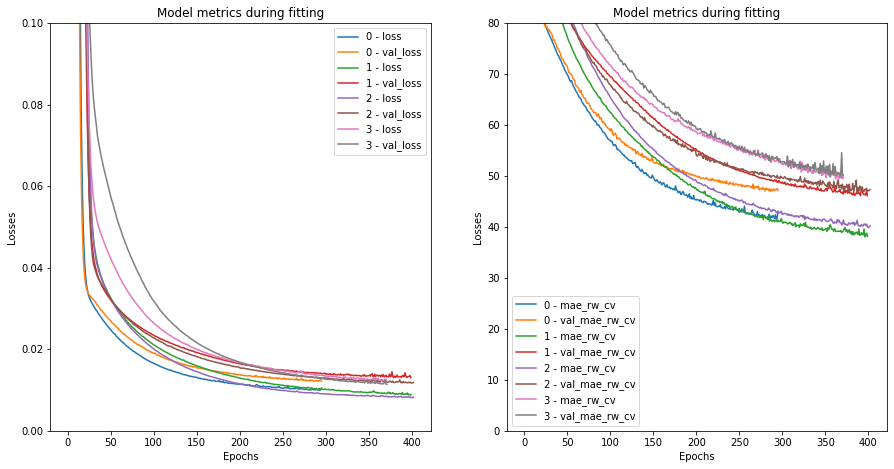

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 7.5]

def plot_history(_history_list):
    """ Plot the evolution of the accuracy and loss of the model fit """
    plt.figure()
    for j, history in enumerate(_history_list):
        # Plotting loss
        plt.subplot(1, 2, 1)
        for key in ['loss', 'val_loss']:
            plt.plot(history.history[key], label='%d - %s' % (j, key))

        plt.title('Model metrics during fitting')
        plt.ylabel('Losses')
        plt.xlabel('Epochs')
        plt.legend()
        plt.ylim([0, 0.10])

        # Plotting MAE
        plt.subplot(1, 2, 2)
        for key in ['mae_rw_cv', 'val_mae_rw_cv']:
            plt.plot(history.history[key], label='%d - %s' % (j, key))

        plt.title('Model metrics during fitting')
        plt.ylabel('Losses')
        plt.xlabel('Epochs')
        plt.legend()
        plt.ylim([0, 80])

plot_history(history_list)


### Plotting results

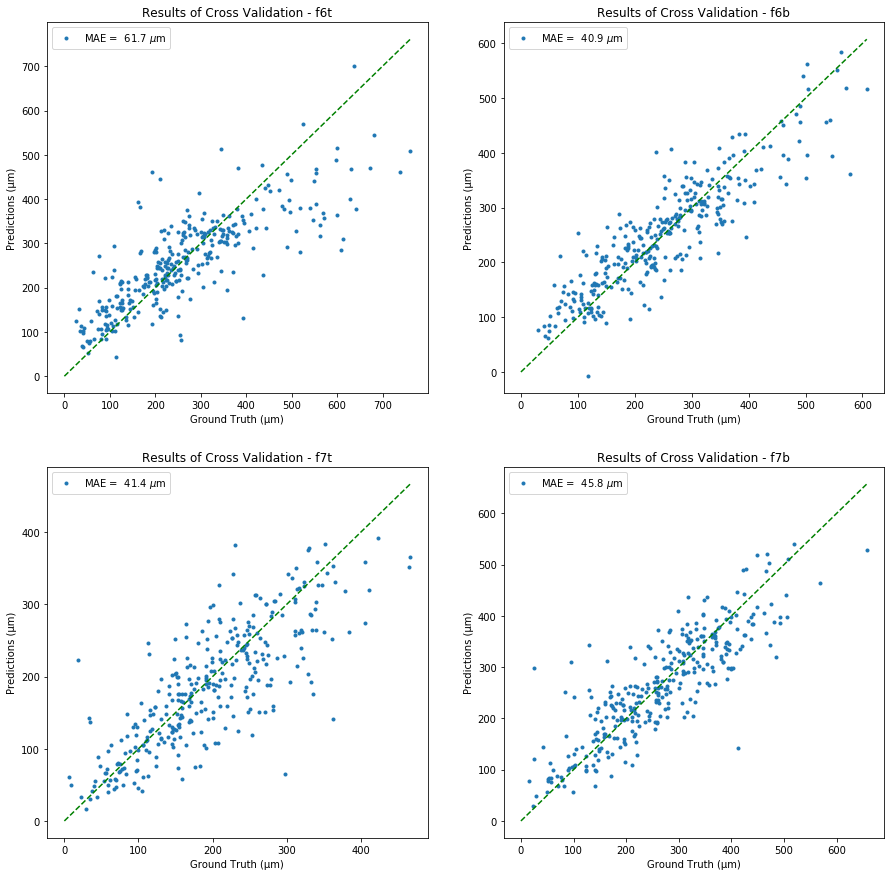

In [12]:
import os 


def plot_results(savefolder_name: str = None):
    """ Plots the results of the model, for each roll
    
    :param savefolder_name: Name of the folder in which results will be saved as csv. If None, nothing is saved
    """
    plt.rcParams['figure.figsize'] = [15, 15]
    
    def plot_one_roll(y, pred, name: str):
        mae = keras.metrics.mae(y, pred)

        plt.plot(y, pred, '.', label=r'MAE =  %.1f $\mu$m' % mae)
        plt.plot([0, y.max()], [0, y.max()], '--g')

        plt.title('Results of Cross Validation - ' + name)
        plt.xlabel('Ground Truth (µm)')
        plt.ylabel('Predictions (µm)')
        plt.legend()

        if savefolder_name is not None:
            df = pd.DataFrame(index=y.index)
            df['Prediction (µm)'] = pred
            df['Ground Truth (µm)'] = y

            path = 'Data/notebooks_data/' + savefolder_name + '_cv/'
            try:
                os.mkdir(path)
            except FileExistsError:
                pass
        
            df.to_csv(path + 'results_cross_val_' + name + '.csv', index=True, float_format='%.2f')

    # Setting to µm
    output, prediction = 1000 * output_df, 1000 * pred_df

    # Plotting results, roll by roll
    names = output_df.keys()
    plt.figure()
    for j, key in enumerate(names):
        plt.subplot(2, np.ceil(len(names) / 2), j + 1)
        plot_one_roll(output[key], prediction[key], names[j])

plot_results('demo')
